# Unidad 5: Modelos estacionarios en series de tiempo

## 5.1 Introducción

Aplicaremos la metodología Box-Jenkins para identificar modelos autoregresivos integrados de media móvil (ARIMA) para analizar y predecir valores futuros de series de tiempo.

## 5.2 Objetivo

Esquematizar los modelos convencionales de series de tiempo a través de la metodología Box-Jenkins para encontrar patrones que nos permitan predecir futuras observaciones.

## 5.3 Acción

Se implementará la metodología de Box-Jenkins para la construcción de un modelo.

### 5.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.
cia en el estudio.

In [11]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

#  remuestreando el dataframe a mensual
df_vcm = df_vcm.resample('M',on='fechaoperacion').mean().reset_index()
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


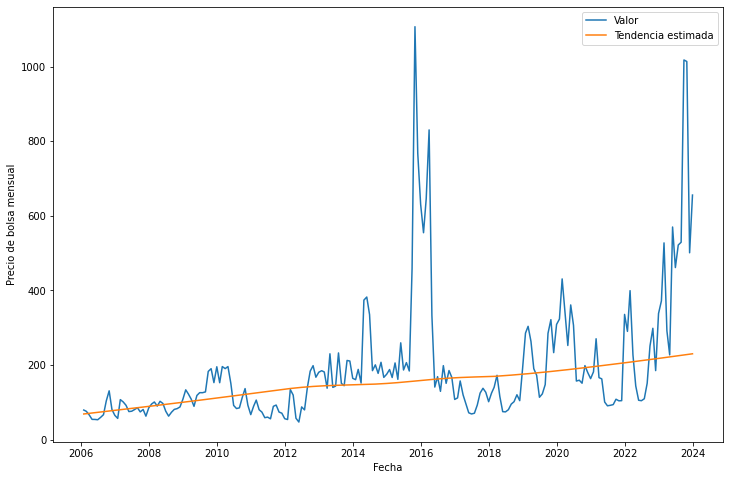

In [9]:
# Graficar la serie de tiempo y su tendencia estimada

# creando lienzo
plt.figure(figsize=(12, 8))

# creando gráfica
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Valor')


lowess = sm.nonparametric.lowess
smoothed = lowess(df_vcm['valor'], df_vcm['fechaoperacion'])
plt.plot(df_vcm['fechaoperacion'], smoothed[:, 1], label='Tendencia estimada')

#
plt.xlabel('Fecha')
plt.ylabel('Precio de bolsa mensual')
plt.legend()
plt.show()

In [12]:
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


In [17]:
# creando nuevo dataframe para analizar boxplot mensual

# creando copia del dataframe transformado
df_mes = df_vcm.copy()

df_mes['mes'] = df_mes.apply(lambda x: x['fechaoperacion'].month,axis=1)

df_mes = df_mes[['mes','valor']]

In [8]:
# Calcular la serie diferenciada
df_vcm['valor_dif'] = df_vcm['valor'].diff().dropna()

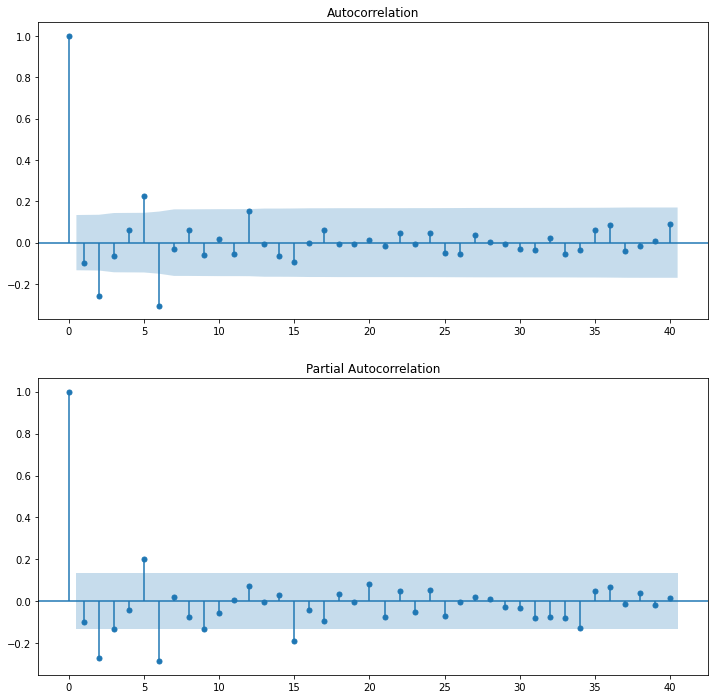

In [9]:
# Graficar ACF y PACF para la serie diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(df_vcm['valor_dif'].dropna(), lags=40, ax=ax1)
plot_pacf(df_vcm['valor_dif'].dropna(), lags=40, ax=ax2)
plt.show()

## Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) para la serie de tiempo diferenciada

El gráfico ACF muestra que las autocorrelaciones se reducen rápidamente, lo cual es típico en un proceso que podría ajustarse bien con un modelo ARIMA.

El gráfico PACF muestra un corte brusco después del primer *lag*, lo que sugiere que un modelo AR(1) podría ser adecuado.

Estos gráficos son útiles para determinar los parámetros \(p\) y \(q\) del modelo ARIMA:

- \(p\) (AR): El número de *lags* que muestran correlaciones significativas en el PACF antes de cortar. En este caso, \(p\) podría ser 1.
- \(q\) (MA): El número de *lags* con correlaciones significativas en el ACF antes de que caiga hacia cero. Aquí, \(q\) podría ser también 1.

In [12]:
# Ajustar un modelo ARIMA(1,1,1) a la serie temporal, usando los parámetros sugeridos por los gráficos ACF y PACF
model = ARIMA(df_vcm['valor'], order=(1, 1, 1))
model_fit = model.fit()

# Mostrar el resumen del modelo ajustado
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1290.861
Date:                Mon, 20 May 2024   AIC                           2587.721
Time:                        16:26:24   BIC                           2597.833
Sample:                             0   HQIC                          2591.807
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7581      0.070     10.867      0.000       0.621       0.895
ma.L1         -0.9530      0.039    -24.198      0.000      -1.030      -0.876
sigma2      9575.1188    302.655     31.637      0.000    8981.925    1.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2871.77
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              28.42   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Resumen del modelo ARIMA(1,1,1) ajustado a la serie de tiempo

El modelo ARIMA(1,1,1) ha sido ajustado nuevamente a la serie de tiempo con los siguientes resultados en el resumen:

- **Coeficiente AR1:** 0.7581
- **Coeficiente MA1:** -0.9530
- **Log Likelihood:** -1290.861
- **AIC:** 2587.721
- **BIC:** 2597.833

Los coeficientes son significativos y el modelo parece ser adecuado dadas las estadísticas proporcionadas. 
Se escoge un modelo ARIMA(1,1,1) cuando la evidencia inicial (como el análisis de las funciones de autocorrelación y autocorrelación parcial) sugiere que estos componentes son suficientes para modelar los datos de manera adecuada. En este caso particular, el modelo ARIMA(1,1,1) fue sugerido inicialmente basado en la observación de los gráficos ACF y PACF, y confirmado por su desempeño en la adaptación de los datos históricos.

Este modelo es particularmente útil cuando se desea un modelo simple que aún sea capaz de capturar las dependencias clave en los datos sin sobreajustar o complicar demasiado el modelo, permitiendo realizar predicciones efectivas y entender la dinámica de la serie de tiempo.

In [13]:
# Hacer predicciones con el modelo ARIMA ajustado para los próximos 24 períodos
forecast_24 = model_fit.get_forecast(steps=24)
forecast_conf_int_24 = forecast_24.conf_int()

# Crear un DataFrame para visualizar las predicciones y los intervalos de confianza para 24 meses
forecast_df_24 = pd.DataFrame({
    'Predicted': forecast_24.predicted_mean,
    'Lower CI': forecast_conf_int_24.iloc[:, 0],
    'Upper CI': forecast_conf_int_24.iloc[:, 1]
})

forecast_df_24

,Predicted,Lower CI,Upper CI
216,596.349781,404.562335,788.137227
217,551.573290,305.360600,797.785979
218,517.630427,241.026309,794.234544
219,491.900006,196.190967,787.609045
220,472.395035,163.790377,780.999693
221,457.609272,139.800605,775.417940
222,446.400911,121.694746,771.107076
223,437.904401,107.796056,768.012746
224,431.463614,96.951888,765.975339
225,426.581168,88.350234,764.812103


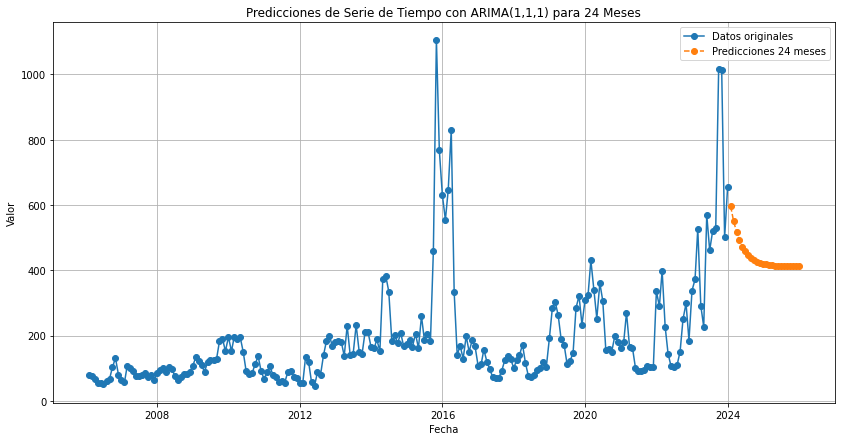

In [14]:
# Generar fechas de predicción para 24 meses
prediction_dates_24 = pd.date_range(start=df_vcm['fechaoperacion'].iloc[-1] + pd.DateOffset(months=1), periods=24, freq='M')

# Graficar la serie original y las predicciones para 24 meses
plt.figure(figsize=(14, 7))
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Datos originales', marker='o')
plt.plot(prediction_dates_24, forecast_24.predicted_mean, label='Predicciones 24 meses', marker='o', linestyle='--')
plt.title('Predicciones de Serie de Tiempo con ARIMA(1,1,1) para 24 Meses')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()